In [20]:
using JuMP, Gurobi, PyPlot, ProgressMeter

env = Gurobi.Env()

function simpleModel(N,M)
    T = N #upper bound on project completion

    #m = Model(solver=CbcSolver)
    m = Model(solver=GurobiSolver(env, OutputFlag=0))

    @variable(m, x[1:N, 1:M, 1:T], Bin)
    @variable(m, last)

    # due to the following two constraints, this just selects the time
    # when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
    @expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

    # each task is only worked on once
    @constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

    # min { max_j end_t[j] }
    @constraint(m, [j=1:N], last >= start_t[j] + 1)

    @objective(m, Min, last)

    solve(m)
    timer = getsolvetime(m)
    return timer
end
                
function discreteTimeModel(N,W)
    # Task/Worker Parameters
    ###############################

    ## We require 5 of task_1, 1 of task_2, etc.
    n = maximum(N) #max number of tasks for a category
    v = size(N,1) # number of types of tasks

    ## Each row of W is a worker, and the column is the time required for the worker to complete that task
    w = size(W,1) #number of workers

    T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

    # Solver
    ###############################
    m = Model(solver=GurobiSolver(env, OutputFlag=0))

    @variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
    @variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

    @variable(m, last)

    #If a worker starts a task at time t, z if true until the tasks completes
    for i=1:n
        for j=1:v
            for k=1:w
                for t=1:T
                    if t < T-convert(Int64,W[k,j])
                        @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                    else
                        @constraint(m, [l=0:T-t], z[i,j,k,t+l] >= x[i,j,k,t])  
                    end
                end
            end
        end
    end

    #only one task in z can be worked simultaneously
    @constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

    #expression is used as an epigraph to find the end time of the last task
    @expression(m, end_t[j=1:n, k=1:v, i=1:w, t=1:T], (z[j,k,i,t])*(t+W[i,k]))
    @expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

    # each task is only worked on once and all tasks are completed
    @constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
    @constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

    # min { max_j end_t[j] }
    @constraint(m, [j=1:n, k=1:v, i=1:w, t=1:T], last >= end_t[j,k,i,t])

    @objective(m, Min, last)    
    solve(m)
    timer = getsolvetime(m)
    return timer
end
                
function binaryTaskBundles(quotas, n_workers)
  
    # Task/Worker Parameters
    ###############################
    m_tasks = length(quotas)
    horizon = maximum(quotas)

    initial_task_lengths = rand(1:10, m_tasks)
    min_task_lengths = max.(1, initial_task_lengths - rand(1:10, m_tasks))
    task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:m_tasks, T in 1:horizon]

    ###############################

    m = Model(solver=GurobiSolver(env, OutputFlag=0))
    @variable(m, work[1:n_workers, 1:m_tasks, 1:horizon], Bin)
    @variable(m, slowest_worker >= 0)

    @expression(m, work_on[j in 1:m_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

    # we must meet quotas
    @constraint(m, quota_constr[j in 1:m_tasks], work_on[j] >= quotas[j])

    # worker speed
    @expression(m, worker_speed[i in 1:n_workers],
        sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:m_tasks))

    for i in 1:n_workers, j in 1:m_tasks
        addSOS1(m, work[i,j,:])
    end

    # ∞-norm epigraph bounds for slowest_worker
    @constraints(m, begin
        worker_speed .<= slowest_worker
        -slowest_worker .<= worker_speed
    end)

    # minimize the amount of time the slowest worker takes
    @objective(m, Min, slowest_worker)
    
    solve(m)
    timer = getsolvetime(m)
    return timer
end

binaryTaskBundles (generic function with 1 method)

Academic license - for non-commercial use only


In [2]:
## have consistent scale factor and averages

scaleFactor = 7
averages = 5

Academic license - for non-commercial use only


5

## Model 1 - Tasks

5 workers, numnber of tasks ranges from 5 to 100

[1]: 100%|██████████████████████████████████████████████| Time: 0:00:20
[2]: 100%|██████████████████████████████████████████████| Time: 0:00:16
[3]: 100%|██████████████████████████████████████████████| Time: 0:00:16
[4]: 100%|██████████████████████████████████████████████| Time: 0:00:16
[5]:  95%|████████████████████████████████████████████  |  ETA: 0:00:01

Relative speed: 

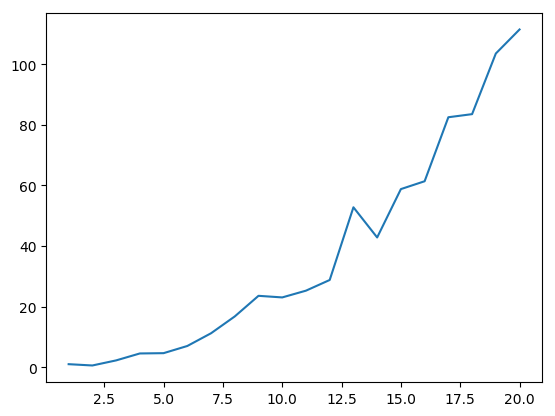

[1.0, 0.57143, 2.24756, 4.53919, 4.63766, 7.00508, 11.2083, 16.7623, 23.5657, 23.0381, 25.2694, 28.7922, 52.7929, 42.8318, 58.7976, 61.3877, 82.5161, 83.5397, 103.553, 111.489]
Timer to solve: [0.0211116, 0.0120638, 0.0474496, 0.0958294, 0.0979084, 0.147888, 0.236624, 0.353878, 0.497509, 0.486371, 0.533477, 0.607848, 1.11454, 0.904248, 1.24131, 1.29599, 1.74205, 1.76366, 2.18616, 2.35371]


[5]: 100%|██████████████████████████████████████████████| Time: 0:00:16


In [3]:
timer = zeros(scaleFactor)

N = 5; W= 5 # task, worker, time inital values
for p=1:averages
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + simpleModel(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 1 - Workers

60 tasks, workers vary from 5 to 100


[1]: 100%|██████████████████████████████████████████████| Time: 0:01:13
[2]: 100%|██████████████████████████████████████████████| Time: 0:01:12
[3]: 100%|██████████████████████████████████████████████| Time: 0:01:12
[4]: 100%|██████████████████████████████████████████████| Time: 0:01:12
[5]:  95%|████████████████████████████████████████████  |  ETA: 0:00:03

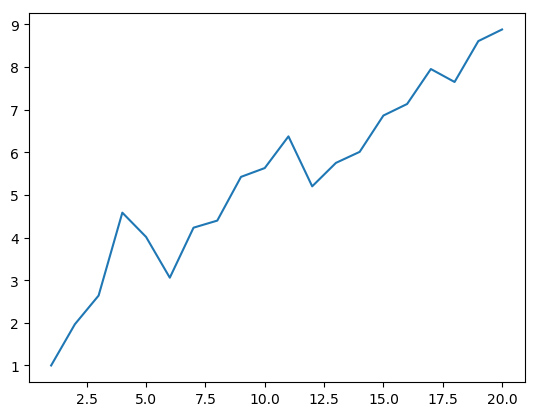

Relative speed: [1.0, 1.96746, 2.64001, 4.58475, 4.01553, 3.05895, 4.23258, 4.39835, 5.4244, 5.63077, 6.37447, 5.20242, 5.75265, 6.01087, 6.86303, 7.13417, 7.9541, 7.65064, 8.60955, 8.88195]
Timer to solve: [0.589677, 1.16016, 1.55675, 2.70352, 2.36786, 1.80379, 2.49586, 2.5936, 3.19865, 3.32033, 3.75888, 3.06775, 3.39221, 3.54447, 4.04697, 4.20686, 4.69035, 4.51141, 5.07685, 5.23748]


[5]: 100%|██████████████████████████████████████████████| Time: 0:01:12


In [4]:
timer = zeros(scaleFactor)

N = 60; W= 5 # task, worker, time inital valuesN = 5; W= 5 # task, worker, time inital values
for p=1:averages
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + simpleModel(N,W*u,)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 2 - Tasks 

Number of workers and task types held constant

Total number of tasks scales

[1]: 100%|██████████████████████████████████████████████| Time: 4:39:38
[2]: 100%|██████████████████████████████████████████████| Time: 3:10:51
[3]: 100%|██████████████████████████████████████████████| Time: 2:18:30
[4]: 100%|██████████████████████████████████████████████| Time: 1:49:47
[5]: 100%|██████████████████████████████████████████████| Time: 3:18:23


Relative speed: 

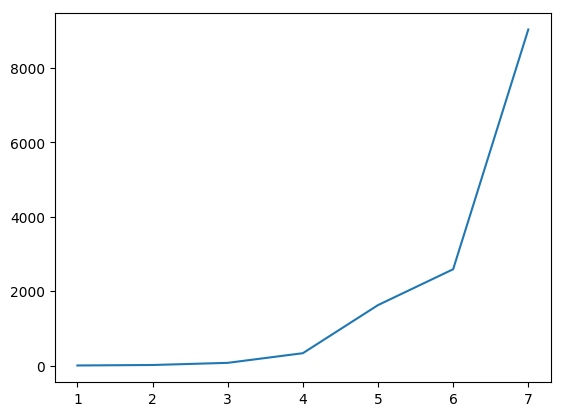

[1.0, 13.9232, 71.6988, 331.081, 1624.28, 2588.54, 9035.07]
Timer to solve: [0.805015, 11.2084, 57.7186, 266.525, 1307.57, 2083.81, 7273.37]


In [5]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker value
    N = rand(3:5,1,3)
    W = rand(1:10,3,3)
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + discreteTimeModel(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 2 - Workers

Number of tasks and types of tasks held constant.  

Number of workers scales

[1]: 100%|██████████████████████████████████████████████| Time: 0:03:53
[2]: 100%|██████████████████████████████████████████████| Time: 0:03:07
[3]: 100%|██████████████████████████████████████████████| Time: 0:02:14
[4]: 100%|██████████████████████████████████████████████| Time: 0:03:12
[5]: 100%|██████████████████████████████████████████████| Time: 0:01:57


Relative speed: 

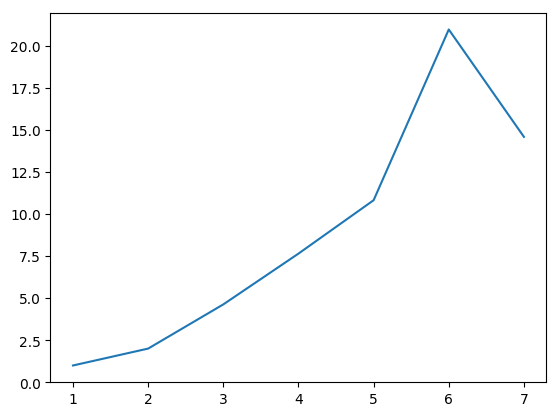

[1.0, 2.00397, 4.62821, 7.64477, 10.8158, 20.9566, 14.5778]
Timer to solve: [2.78291, 5.57686, 12.8799, 21.2747, 30.0995, 58.3202, 40.5689]


In [3]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(3:5,1,5)
    W = rand(1:10, 2,5)
    @showprogress "[$p]: " for u=1:scaleFactor
        W = [W; rand(1:10, 2,5)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 2 - Task Variety
Number of workers and tasks held constant.

Variety of task types scales


[1]: 100%|██████████████████████████████████████████████| Time: 0:00:41
[2]: 100%|██████████████████████████████████████████████| Time: 0:01:16
[3]: 100%|██████████████████████████████████████████████| Time: 0:01:29
[4]: 100%|██████████████████████████████████████████████| Time: 0:01:02
[5]:  83%|██████████████████████████████████████        |  ETA: 0:00:10

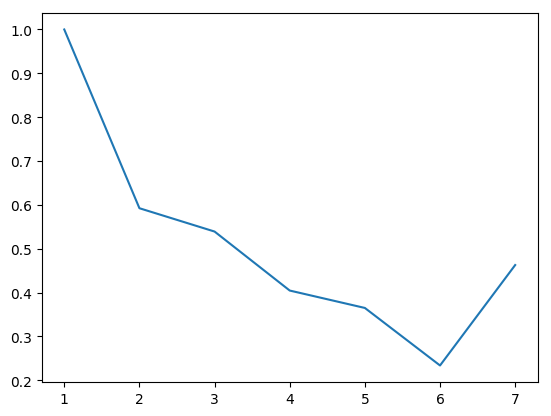

Relative speed: [1.0, 0.592412, 0.539217, 0.404689, 0.365005, 0.233833, 0.462855]
Timer to solve: [24.6548, 14.6058, 13.2943, 9.97754, 8.99915, 5.76513, 11.4116]


[5]: 100%|██████████████████████████████████████████████| Time: 0:00:58


In [4]:
timer = zeros(scaleFactor)


for p=1:averages
    # task, worker values
    N = 20
    W = rand(1:10,3,1)
    timer[1] = timer[1] + discreteTimeModel(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = round.(Int, 20./u .* ones(u))
        W = [W rand(1:10, 3,1)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 2 - Task Variety, tasks number scales accordingly.
Number of workers constant

Variety of task types scales, and each task is done the same number of times.


[1]: 100%|██████████████████████████████████████████████| Time: 0:09:26
[2]: 100%|██████████████████████████████████████████████| Time: 0:09:08
[3]: 100%|██████████████████████████████████████████████| Time: 0:07:10
[4]: 100%|██████████████████████████████████████████████| Time: 0:06:35
[5]:  83%|██████████████████████████████████████        |  ETA: 0:01:01

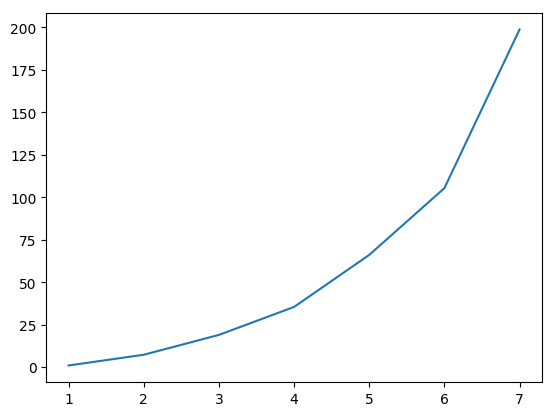

Relative speed: [1.0, 7.31853, 18.9964, 35.4565, 66.0749, 105.345, 198.716]
Timer to solve: [1.10657, 8.09846, 21.0209, 39.2351, 73.1165, 116.572, 219.893]


[5]: 100%|██████████████████████████████████████████████| Time: 0:07:37


In [6]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,1)
    W = rand(1:10,3,1)
    timer[1] = timer[1] + discreteTimeModel(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = [N rand(8:12,1,1)]
        W = [W rand(1:10, 3,1)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Binary Task Bundles - Workers
n_tasks, quotas constant

n_workers is scaled

Relative speed: 

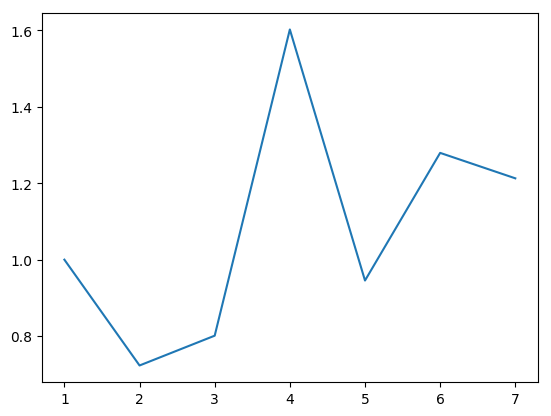

[1.0, 0.723176, 0.801136, 1.60223, 0.945441, 1.27937, 1.21281]
Timer to solve: [0.00899849, 0.00650749, 0.00720901, 0.0144176, 0.00850754, 0.0115124, 0.0109135]


In [21]:
using JuMP, Gurobi, ProgressMeter

timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(3:5,1,5)
    @showprogress "[$p]: " 
    for u=1:scaleFactor
        W = 2*u
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Binary Task Bundles - Tasks
number of workers and number of task types is constant

number of tasks scales


[1]: 100%|██████████████████████████████████████████████| Time: 0:00:00
[4]: 100%|██████████████████████████████████████████████| Time: 0:00:00
[5]: 100%|██████████████████████████████████████████████| Time: 0:00:00


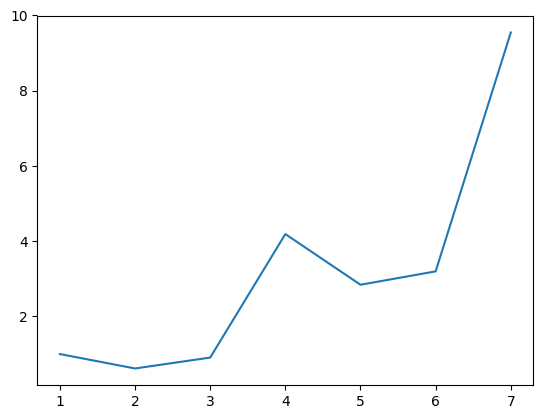

Relative speed: [1.0, 0.616814, 0.906563, 4.18712, 2.84129, 3.19652, 9.54257]
Timer to solve: [0.0107128, 0.00660782, 0.00971184, 0.0448559, 0.0304382, 0.0342438, 0.102228]


In [22]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(3:5,1,5)
    W = 3
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + binaryTaskBundles(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Binary Task Bundles - Task Type
Number of workers and total tasks are constant
Number of task types scales

[1]: 100%|██████████████████████████████████████████████| Time: 0:00:00


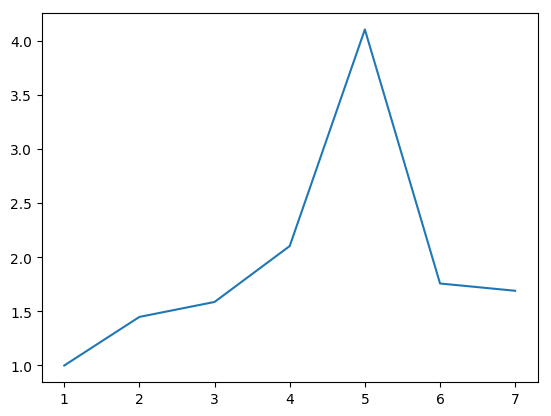

Relative speed: [1.0, 1.44862, 1.58673, 2.10315, 4.10342, 1.75729, 1.69001]
Timer to solve: [0.00290298, 0.00420532, 0.00460625, 0.00610542, 0.0119122, 0.00510139, 0.00490608]


In [23]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = 20
    W = 3
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = round.(Int, 20/u * ones(u))
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Binary Task Bundles - Tasks and Variety
Number of workers held constant
Number of tasks scales, and total quota scales

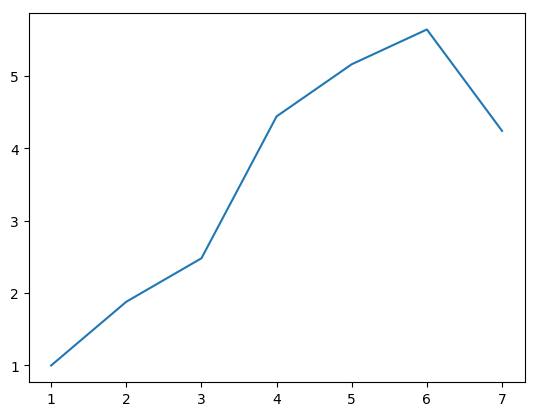

Relative speed: [1.0, 1.88074, 2.48162, 4.44228, 5.16288, 5.64328, 4.24203]
Timer to solve: [0.0025013, 0.00470428, 0.00620728, 0.0111115, 0.0129139, 0.0141155, 0.0106106]


In [24]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,1)
    W = 3
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = [N rand(8:12,1,1)]
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)